# Rossby wave Model with 5 modes
## This jupyter notebook test inverse problem with swath samples

#### First we calculate the Brunt-Vaisla frequency squared with a sample dataset.

In [1]:
import numpy as np
import scipy
import gsw
import xarray as xr
import cmocean as cmo
from numpy import linalg as LA
from scipy import linalg

In [2]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
state_ds = xr.open_dataset('../../Rossby_wave_test_case/MARA_RUN2_SWOT_state_2015-01-06.nc')
#state_ds #.PHIHYD #, state_ds.DRHODR

In [4]:
LAT, LON = state_ds.YC.data, state_ds.XC.data

In [5]:
lat, lon = np.meshgrid(LAT, LON)

# Read Temperature, Salinity and Pressure data

In [6]:
temp = state_ds.THETA
salinity = state_ds.SALT
Z = state_ds.Z
pres_anomalies  =  state_ds.PHIHYD

# Calculate Brunt-Vaisla frequency squared

In [7]:
SA, CT = np.ma.masked_all(salinity.shape), np.ma.masked_all(temp.shape)
Nsquared = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
Pressure_mid = np.ma.masked_all([salinity.shape[0]-1,salinity.shape[1], salinity.shape[2]])
pres = np.ma.masked_all([salinity.shape[0],salinity.shape[1], salinity.shape[2]])
Z_mid = np.ma.masked_all([salinity.shape[0]-1, salinity.shape[1], salinity.shape[2]])
for y in range(SA.shape[1]):
    for x in range(SA.shape[2]):
        pres[:, y, x] = gsw.p_from_z(Z.data,  lat = LAT[y]) #+ pres_anomalies.data[:, y, x]
        SA[:, y, x] = gsw.conversions.SA_from_SP(salinity.data[:, y, x], pres.data[:, y, x], LON[x], LAT[y])
        CT[:, y, x] = gsw.CT_from_pt(SA.data[:, y, x], temp.data[:, y, x])  
        Nsquared[:, y, x], Pressure_mid[:, y, x] = gsw.stability.Nsquared(SA[:, y, x], CT[:, y, x], pres[:, y, x])
        Z_mid[:, y, x] = gsw.z_from_p(Pressure_mid[:, y, x] , lat = LAT[y])

In [8]:
xlon, ylat = np.meshgrid(LON, LAT)

In [9]:
zz, yy = np.meshgrid(Z[1:], LAT)

### Choose a vector at a random location

In [10]:
laty, lonx = 130, 220

## Interpolate the N2 vector onto a uniform pressure grid

In [11]:
N2_vector = Nsquared[:, laty, lonx]
Pmid_vector = Pressure_mid[:, laty, lonx]
#Pmid_vector, N2_vector
for i in range(len(N2_vector)-1):
    if N2_vector[i] < 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))
    if N2_vector[i] == 0:
        N2_vector[i] = N2_vector[i+1] #np.median(np.absolute(N2_vector))

In [12]:
Pmid_uniform = np.arange(Pmid_vector[0], Pmid_vector[-1], step = 120)
N2_uniform = np.interp(Pmid_uniform, Pmid_vector[:-2], N2_vector[:-2])

In [13]:
Pmid_uniform = Pmid_uniform[:]
N2_uniform = N2_uniform[:]
#Pmid_uniform[:-16], N2_uniform[:-16]

In [14]:
import VERT_FSFB3

In [15]:
c2, Psi, G, N2, Pmid = VERT_FSFB3.VERT_FSFB3(N2_uniform[:-16], Pmid_uniform[:-16])

In [16]:
g = 9.81 # gravity

## With a rigid lid assumpsion, SSH = Gm/g, where g is gravity, since hydrastatic pressure p = $rho * g *  SSH$

In [17]:
SSH = G/g

In [18]:
Z_mid_uniform  = gsw.z_from_p(np.append(0,Pmid), lat = laty)

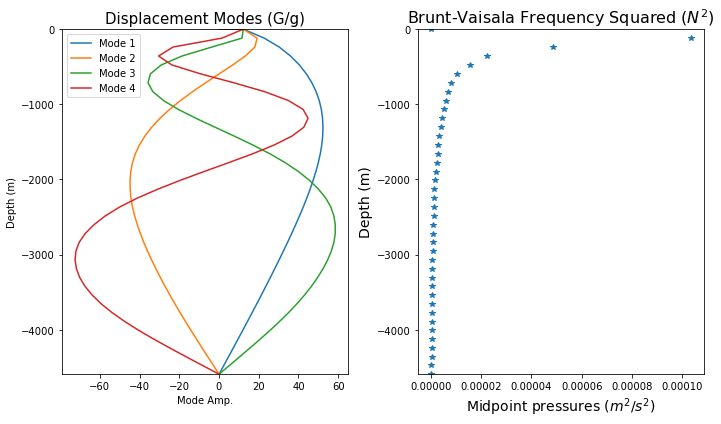

In [19]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plt.plot(SSH[:,0], Z_mid_uniform, label = 'Mode 1')
plt.plot(SSH[:,1], Z_mid_uniform, label = 'Mode 2')
plt.plot(SSH[:,2], Z_mid_uniform, label = 'Mode 3')
plt.plot(SSH[:,3], Z_mid_uniform, label = 'Mode 4')
#plt.plot(SSH[:,4], Z_mid_uniform, label = 'Mode 5')
plt.xlabel('Mode Amp.')
plt.ylabel('Depth (m)')
#plt.xlim([-.2, .2])
plt.ylim([Z_mid_uniform.min(), 0])
plt.legend()
plt.title('Displacement Modes (G/g)', fontsize = 15)

plt.subplot(122)
plt.title('Brunt-Vaisala Frequency Squared ($N^2$)', fontsize = 16)
plt.plot(N2, Z_mid_uniform[1:], '*')
#plt.plot(Pmid_vector[:], N2_vector,  linewidth  = 2.0)
plt.xlabel('Midpoint pressures (${m^2}/{s^2}$)', fontsize = 14)
plt.ylabel('Depth (m)', fontsize = 14)
#plt.xlim([10, 350])
plt.ylim([Z_mid_uniform.min(), 0])

plt.tight_layout()
plt.savefig('vertical_modes_N2_sample_CCS_lon_' + str(lonx) + '_lat_' + str(laty) +'.png')

In [20]:
MODE = G.shape[-1]

In [21]:
Zgrid, mode = np.meshgrid(Z_mid_uniform, range(MODE) )

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_42716/53837551.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_42716/53837551.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_42716/53837551.py:25: MatplotlibDeprec

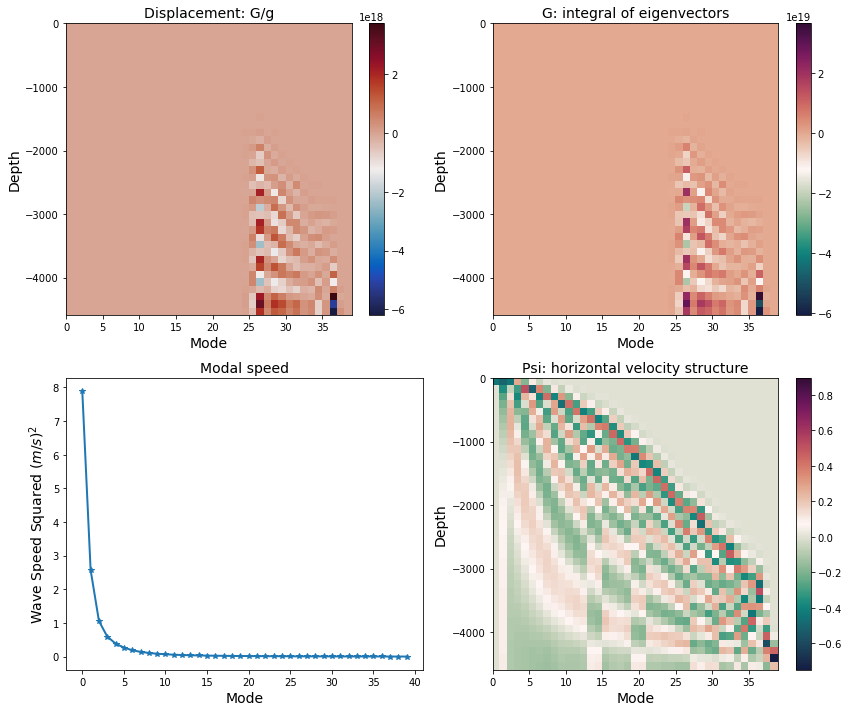

In [22]:
plt.figure(figsize = (12, 10))
plt.subplot(221)
plt.title('Displacement: G/g', fontsize = 14)
plt.pcolormesh(mode, Zgrid, SSH[:].T, cmap = cmo.cm.balance)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(222)
plt.title('G: integral of eigenvectors', fontsize = 14)
plt.pcolor(mode, Zgrid,G[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.subplot(223)
plt.title('Modal speed' , fontsize = 14)
plt.plot(c2[:], "-*", linewidth = 2)
plt.ylabel('Wave Speed Squared $(m/s)^2$', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
#plt.colorbar()

plt.subplot(224)
plt.title('Psi: horizontal velocity structure' , fontsize = 14)
plt.pcolor(mode, Zgrid, Psi[:].T, cmap = cmo.cm.curl)
plt.ylabel('Depth', fontsize = 14)
plt.xlabel('Mode', fontsize = 14)
plt.colorbar()

plt.tight_layout()
plt.savefig('vertical_modes_FSFB2_N2_sample_lon_' + str(lonx) + '_lat_' + str(laty) +'.png', dpi = 100)

### Beta plane paramters

In [23]:
Phi0 = 30 # central latitude (φ0)
Omega = 7.2921159e-5 # Ω is the angular speed of the earth
Earth_radius = 6.371e6 # meters
Beta = 2 * Omega * np.cos(Phi0) / Earth_radius
f0 = 2 * Omega * np.sin(Phi0) #1.0313e-4 # 45 N

### SSH - 15 waves, 5 baroclinic modes, 3 wavenumbers, 5 modes, 15 frequencies, 30 amplitudes

#### The dispersion relation relates frequency to wavenumber for each mode:

In [24]:
MModes = 5 # 
wavelength = np.array([2e5, 1e5, .5e5]) # 200km, 100km, 50km
wavespeed = c2[:MModes] # Phase speed
k_n = 2 * np.pi / wavelength # wavenumber
Rm = wavespeed[:MModes] / f0 # Rossby deformation radius
wavelength_l = 0.4 * wavelength
l_n = 2 * np.pi / wavelength_l # Y direction wavenumber

freq_n = np.zeros([len(wavelength), MModes])
for nn in range(len(k_n)):
    for mm in range(MModes):
        freq_n[nn, mm] = (Beta * k_n[nn]) / (k_n[nn] ** 2 + l_n[nn] ** 2 + Rm[mm] ** (-2))
#Amp = np.array([[.5, .4, .3, .2, .4, 0.1, .9,  .8,  .7,  .6,  .5,  .4, .3, .2, .5],
#                [.3, .2, .4, .2, .3, .4, .5, .6, .4, .2, .4, .2, .4, .6, .8]]).reshape([2, MModes, len(wavelength)], order = 'C')
Amp = np.random.rand(2, MModes, len(wavelength))
M = Amp.size
Amp

array([[[0.84822781, 0.96211338, 0.13504351],
        [0.47145659, 0.04167264, 0.04220071],
        [0.88606373, 0.13272009, 0.63479392],
        [0.33451174, 0.29911413, 0.98251468],
        [0.85800187, 0.32095999, 0.15593915]],

       [[0.38025544, 0.2570865 , 0.20088482],
        [0.48254579, 0.88420912, 0.68651205],
        [0.79614227, 0.29011133, 0.5783647 ],
        [0.76702098, 0.20570963, 0.00350948],
        [0.48339354, 0.95509526, 0.47200526]]])

In [25]:
X_loc = np.arange(0, 1e6, 1e4) # domain size 1000 km with 10km resolution
Y_loc = np.arange(0, 1e6, 1e4)
T_time = np.arange(0, 1e10, 1e8) # Time step : ~11days

### H Matrix and SSH

In [26]:
%%time
H_cos = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)] ) # Number of waves * Number of data
H_sin = np.zeros([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
SSH_XYTMN = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes, len(wavelength)])
for tt in range(len(T_time)):
    for xx in range(len(X_loc)):
        for yy in range(len(Y_loc)):
            for mm in range(Amp.shape[1]):
                for nn in range(len(k_n)):
                    H_cos[tt, xx, yy, mm, nn] = Psi[0, mm] * np.cos(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt]) 
                    H_sin[tt, xx, yy, mm, nn] = Psi[0, mm] * np.sin(k_n[nn] * X_loc[xx] + l_n[nn] * Y_loc[yy] + freq_n[nn, mm] * T_time[tt])

for mm in range(MModes):
    for nn in range(len(k_n)):
        SSH_XYTMN[:, :, :, mm, nn] = Amp[0, mm, nn] * H_cos[:, :, :, mm, nn] + Amp[1, mm, nn] * H_sin[:, :, :, mm, nn]

CPU times: user 1min 3s, sys: 426 ms, total: 1min 4s
Wall time: 1min 4s


#### Add up long the last two axis: modes, frequences

In [27]:
SSH_XYT = np.sum(SSH_XYTMN, axis = (-1, -2))

### Exact-solution - Solve 30 unknow amplitudes with 30 data points.

In [28]:
tindex= np.random.randint(low = 0, high= 99, size= 2000)
yindex = np.random.randint(low = 0, high= 99, size= 2000) #np.array([4, 32, 61, 86, 92, 99])
xindex = np.random.randint(low = 0, high= 99, size= 2000) #np.array([15, 20, 30, 40, 55, 60]) 
y_m = SSH_XYT[tindex, xindex, yindex].data
M, N = Amp.size, y_m.size

In [29]:
H_ = np.ma.masked_all([len(T_time), len(X_loc), len(Y_loc), MModes*2, len(wavelength)]) # Number of data * Number of models
H_[:, :, :, 0::2] = H_cos #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')
H_[:, :, :, 1::2] = H_sin #.reshape([len(T_time), len(X_loc), len(Y_loc), 15], order='F')

In [30]:
# Convert the T, X, Y space to 1-dimensional space
IIndex = np.zeros(N) # N: Number of y data
Y_v = np.zeros(N) 
H_v = np.zeros([N, M]) # M: number of model
nx, ny = N, N
for iii in range(N):
    IIndex[iii] = nx * ny * tindex[iii] + ny * xindex[iii] + xindex[iii]
    Y_v[iii] = SSH_XYT[tindex[iii], xindex[iii], yindex[iii]]
    for mm in range(MModes):
        for nn in range(len(wavelength)):
            H_IIndex = nx * ny * tindex[iii] + ny * xindex[iii] + xindex[iii] ## Data space
            JIndex = 2 * MModes * nn +  2 * mm  # Model space
            H_v[iii, JIndex] = H_cos[tindex[iii], xindex[iii], yindex[iii], mm, nn]
            H_v[iii, JIndex + 1] = H_sin[tindex[iii], xindex[iii], yindex[iii], mm, nn]

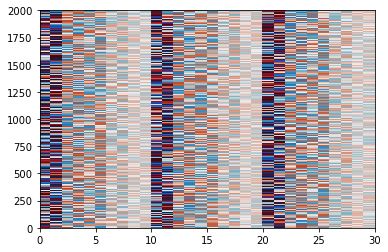

In [31]:
plt.pcolor(H_v, cmap = cmo.cm.balance)

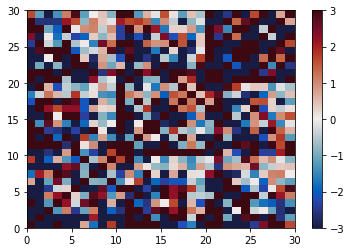

In [32]:
plt.pcolor(np.matmul(H_v.T, H_v), vmin = -3, vmax = 3, cmap = cmo.cm.balance)
plt.colorbar()

#### Weighted least square solution

In [33]:
num_samples = len(Y_loc)
noise_std = 2

#### R and P Matrix

In [34]:
R_ = np.eye(N, N)

In [35]:
P_ = np.eye(M, M)

In [36]:
for ii in range(N):
    R_[ii, ii] = .01 #(residual * 0.7) ** 2 # (half of the variance is noise) 1e-6  # Uncertainty in data

for ii in range(M):    
    P_[ii, ii] = 1 # Uncertainty in model

#### P matrix =0 For now

In [37]:
A = np.matmul(H_v.T, LA.inv(R_))

In [38]:
HRH = np.matmul(A, H_v)

In [39]:
D = np.matmul(np.matmul(LA.inv(HRH + LA.inv(P_)), H_v.T) , LA.inv(R_))

In [40]:
eig, vec = LA.eig(HRH)
eig.real

array([107559.62864717, 105041.05778682,  74730.40059362,  84168.23587439,
        79915.42131836,  81341.44171295,  26418.27165151,  25709.42744775,
        24907.06706186,  25401.59844702,  20897.4962606 ,  20166.45540018,
        19621.82503604,  19032.73592654,  18739.44404483,  18257.48030786,
          434.87233214,    467.06501013,   8081.29934104,   7938.70134562,
         7018.31727128,   7057.27709926,   7307.61816344,   7504.4304421 ,
         3554.71057038,   3356.57695988,   2932.37182952,   3199.30219346,
         3088.4421473 ,   3044.21709355])

#### Soution with noise

In [41]:
X_ = np.matmul(D, Y_v)

In [42]:
SOL_WN = X_ #.reshape([2, MModes, len(wavelength)], order = 'C')

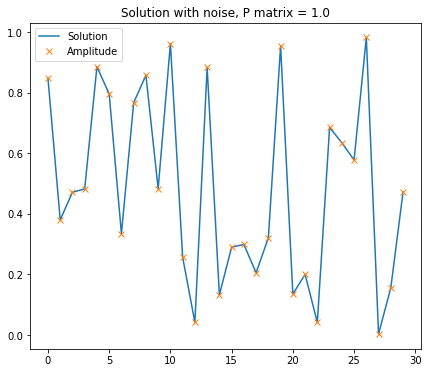

In [43]:
plt.figure(figsize = (7,6))
plt.plot(SOL_WN, label = 'Solution')
plt.plot(Amp.reshape([30], order = 'F'),'x',label = 'Amplitude')
plt.legend()
plt.title('Solution with noise, P matrix = ' + str(P_[0, 0]))
plt.savefig('inverse_problem_solution_N' + str(N)+'.png')

In [44]:
SOL_WN, Amp.reshape([M], order = 'F')

(array([0.84821187, 0.38024806, 0.47143381, 0.48251858, 0.88602816,
        0.79608988, 0.33445851, 0.76687382, 0.85771837, 0.48326383,
        0.96210797, 0.25708337, 0.04165285, 0.88416688, 0.13271981,
        0.29010191, 0.29907702, 0.20570982, 0.32085587, 0.95480665,
        0.13509125, 0.20024229, 0.04173323, 0.68538082, 0.63489895,
        0.57809671, 0.98237513, 0.00359507, 0.1559217 , 0.47191461]),
 array([0.84822781, 0.38025544, 0.47145659, 0.48254579, 0.88606373,
        0.79614227, 0.33451174, 0.76702098, 0.85800187, 0.48339354,
        0.96211338, 0.2570865 , 0.04167264, 0.88420912, 0.13272009,
        0.29011133, 0.29911413, 0.20570963, 0.32095999, 0.95509526,
        0.13504351, 0.20088482, 0.04220071, 0.68651205, 0.63479392,
        0.5783647 , 0.98251468, 0.00350948, 0.15593915, 0.47200526]))

#### Check whether Y == Hx

In [45]:
np.mean(np.matmul(H_v, SOL_WN) - Y_v)

-3.443036930749715e-06

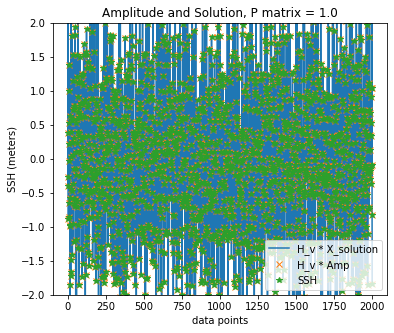

In [47]:
plt.figure(figsize = (6, 5))
plt.plot(np.matmul(H_v, SOL_WN), label = 'H_v * X_solution')
plt.plot(np.matmul(H_v, Amp.reshape([M], order = 'F')), 'x', label = 'H_v * Amp')
plt.plot(Y_v, '*', label = 'SSH')
plt.xlabel('data points')
plt.ylabel('SSH (meters)')
plt.legend(loc = 'best')
plt.ylim([-2, 2])
plt.title('Amplitude and Solution, P matrix = ' + str(P_[0, 0]) )
plt.savefig('SSH_Hv_X_solution_P'+ str(P_[0, 0])  +'.png')

Text(0.5, 1.0, 'Amplitude and Solution, P matrix = 1.0')

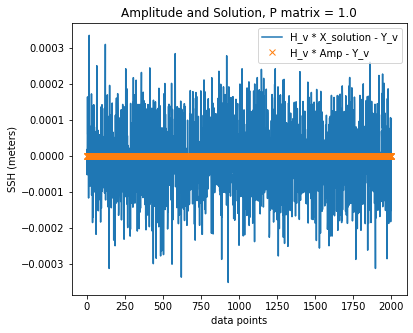

In [48]:
plt.figure(figsize = (6, 5))
plt.plot(np.matmul(H_v, SOL_WN)- Y_v, label = 'H_v * X_solution - Y_v')
plt.plot(np.matmul(H_v, Amp.reshape([M], order = 'F')) - Y_v, 'x', label = 'H_v * Amp - Y_v')
#plt.plot(Y_v, '*', label = 'SSH')
plt.xlabel('data points')
plt.ylabel('SSH (meters)')
plt.legend(loc = 'best')
#plt.ylim([-2, 2])
plt.title('Amplitude and Solution, P matrix = ' + str(P_[0, 0]) )
#plt.savefig('SSH_Hv_X_solution_P'+ str(P_[0, 0])  +'.png')

#### Batch plot and make movie

In [49]:
for tt in range(len(T_time)):
    plt.figure(figsize = (12, 9))
    plt.pcolor(X_loc/1e3, Y_loc/1e3, SSH_XYT[tt], cmap = cmo.cm.balance, vmin = -2., vmax = 2. )
    plt.xlabel('Distance(km)')
    plt.ylabel('Distance(km)')
    plt.title('Time ' + str(tt/1e6) + ' 1e6 seconds')
    plt.colorbar()
    plt.savefig('./SSH_XYT_30waves_5modes/SSH_XYT_' + str(T_time[tt]/1e6).zfill(4) + '.png')
    plt.close()

/var/folders/4w/wvmyk9216kl39tqqrtqcndl80000gn/T/ipykernel_42716/1631298850.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(X_loc/1e3, Y_loc/1e3, SSH_XYT[tt], cmap = cmo.cm.balance, vmin = -2., vmax = 2. )


In [50]:
def make_gif(*, pic_path, gif_path):
    '''
    pic_path: full path and name of picture input(eg.:'./adv_ml_05d/adv_ml*.png')
    gif_path: full path an name if the gif output(eg.:'./adv_ml_05d.gif')
    '''
    
    import imageio
    import glob
    
    images = []
    imagenames = glob.glob(pic_path)
    imagenames = sorted(imagenames[0::5])
    for filename in imagenames:
        images.append(imageio.imread(filename))
    imageio.mimsave(gif_path, images)

In [51]:
make_gif(pic_path = './SSH_XYT_30waves_5modes/SSH_XYT_*.png', gif_path='./SSH_XYT_30waves_5modes_NEW.gif')